# **OpenFoodFact**

# A. IMPORT


In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
import joblib

from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_nutri = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nutri.csv")
df_nutri.info()
df_nutri.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190804 entries, 0 to 190803
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Cholesterol      190804 non-null  float64
 1   Fat              190804 non-null  float64
 2   Fiber            190804 non-null  float64
 3   Saturated fat    190804 non-null  float64
 4   Trans fat        190804 non-null  float64
 5   Carbohydrates    190804 non-null  float64
 6   Protein          190804 non-null  float64
 7   Sodium           190804 non-null  float64
 8   Sugars           190804 non-null  float64
 9   Energy_kcal      190804 non-null  float64
 10  Additives_count  190804 non-null  int64  
 11  nutri_score      190804 non-null  float64
 12  nutri_grade      190804 non-null  object 
dtypes: float64(11), int64(1), object(1)
memory usage: 18.9+ MB


,Cholesterol,Fat,Fiber,Saturated fat,Trans fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives_count,nutri_score,nutri_grade
0,0.0,0.0,10.0,0.0,0.0,83.33,0.0,0.0,66.67,300.0,0,3.0,c


#**B. Regression**

##1. Visualize the distribution of the label

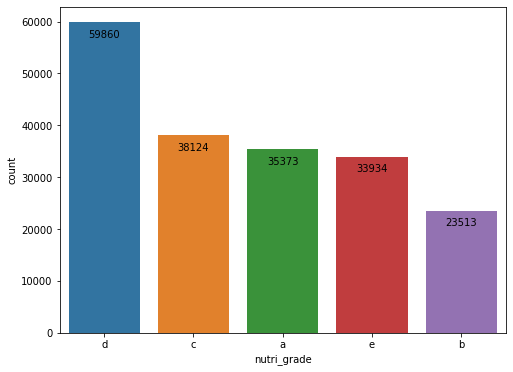

In [ ]:
nutri_count = df_nutri['nutri_grade'].value_counts().reset_index()
nutri_count = nutri_count.rename(columns={'index':'nutri_grade','nutri_grade':'count'})
nutri_count.sort_values('count',ascending=False,inplace=True)

plt.figure(figsize=(8,6))
plt.subplot()
nplot = sns.barplot(data=nutri_count, x='nutri_grade',y='count',order=nutri_count['nutri_grade'].values)

for p in nplot.patches:
  nplot.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va='center',
                 xytext=(0,-12),
                textcoords = 'offset points')
plt.show()

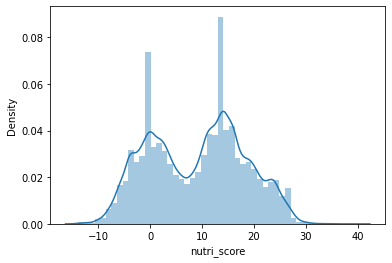

In [ ]:
sns.distplot(df_nutri.nutri_score)

##Split data

In [ ]:
X = df_nutri.drop(columns=['nutri_score', 'nutri_grade'])
y = df_nutri['nutri_score']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(133562, 11) (133562,)
(57242, 11) (57242,)


In [ ]:
# Get a smaller sample size for faster training
def get_samples(n_samples, X, y=None):
  """Get n_samples randomly from dataset"""
  np.random.seed(42)
  samples_index = np.random.choice(np.arange(len(X)), n_samples, replace=False)
  if not y is None:
    return X.iloc[samples_index], y.iloc[samples_index]  
  return X.iloc[samples_index]

n_samples = 50000
X_train_sample, y_train_sample = get_samples(n_samples, X_train, y_train)

##**Benchmark**

In [ ]:
models_dict = {"Dummy Regressor": DummyRegressor(),
               "Linear Regression": LinearRegression(),
               "RandomForestRegressor": RandomForestRegressor()
  }

metrics = {"Mean Squared Error": "neg_mean_squared_error",
           "Mean Absolute Error": "neg_mean_absolute_error"}
           
cv = KFold(n_splits=5, shuffle=True, random_state=42)           

In [ ]:
# Benchmark cross-validation scores for training data of 180K
for model_name, model in models_dict.items():
  print(model_name + ":")
  for metric_name, metric in metrics.items():
    # pipe = Pipeline([('smt', SMOTE(random_state=42)),  # Smote give nan scores?
    #                 ('scaler',StandardScaler()),
    #                 (model_name, model)
    #                 ])

    pipe = Pipeline([('scaler',StandardScaler()),
                    ('model', model)])
    
    score = np.mean(cross_val_score(pipe, X_train, y_train, cv=cv, scoring= metric))
    print("\t" + metric_name + f": {-1*score}")
  # print("\n")

Dummy Regressor:
	Mean Squared Error: 83.46600696869699
	Mean Absolute Error: 7.884146029359295
Linear Regression:
	Mean Squared Error: 25.153489998042236
	Mean Absolute Error: 3.909185739375714
RandomForestRegressor:
	Mean Squared Error: 2.0838828283593047
	Mean Absolute Error: 0.5662850303570467


**Comment:** Random Forest Regressor has the highest scores for all metrics and will be fine-tuned for the Final Model 

In [ ]:
pipe_dum = Pipeline([('scaler',StandardScaler()),
                    ('model',DummyRegressor())
                    ])

pipe_ln = Pipeline([('scaler',StandardScaler()),
                    ('model',LinearRegression())
                    ])

pipe_dtr = Pipeline([('scaler',StandardScaler()),
                    ('model',DecisionTreeRegressor())
                    ])

pipe_rfr = Pipeline([('scaler',StandardScaler()),
                    ('model',RandomForestRegressor())
                    ])

In [ ]:
#put in df

def baseline_report_cv_(model, X_train, y_train, n_splits, name):
  cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)   

  mse     = -np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_squared_error'))
  mae      = -np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='neg_mean_absolute_error'))

  scores_df = pd.DataFrame({'model'        : [name],
                             'MSE'     : [mse],
                             'MAE'      : [mae]})
  return scores_df

In [ ]:
scores_df = pd.concat([baseline_report_cv_(pipe_dum, X_train, y_train, 5, 'DummyRegressor'),
                       baseline_report_cv_(pipe_ln, X_train, y_train, 5, 'LinearRegression'),
                       baseline_report_cv_(pipe_dtr, X_train, y_train, 5, 'DecisionTreeRegressor'),
                       baseline_report_cv_(pipe_rfr, X_train, y_train, 5, 'RandomForestRegressor')
                       ], axis=0).reset_index()

In [ ]:
scores = scores_df.drop("index", axis=1)
scores

,model,MSE,MAE
0,DummyRegressor,82.061115,7.828628
1,LinearRegression,12.697420,2.653486
2,DecisionTreeRegressor,3.523542,0.627613
3,RandomForestRegressor,1.876070,0.538586


In [ ]:
scores.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/nutri_benchmark_df.csv", index=False)

##Fine-tuning Best model

In [ ]:
param_grid = [
    {'model__n_estimators': [3, 5, 10, 15, 20, 30], 
     'model__max_features': list(range(2,10))}
  ]

pipe_rfr = Pipeline([('scaler',StandardScaler()),
                    ('model',RandomForestRegressor())
                    ])

cv=KFold(n_splits=5, random_state=42, shuffle=True)
rfr_gs = GridSearchCV(pipe_rfr, param_grid, cv=cv,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

rfr_gs.fit(X_train, y_train)

print("Best params:", rfr_gs.best_params_)
print("MSE:", -rfr_gs.best_score_)
print("RMSE:", np.sqrt(-rfr_gs.best_score_))

Best params: {'model__max_features': 7, 'model__n_estimators': 30}
MSE: 2.041358390347494
RMSE: 1.4287611383109124


The lowest **MSE** on training set that Random Forest Regressor model can achieve is 2.041 and lowest **RMSE** is 1.43

##Final Cross-Validation on Test set

In [ ]:
# retrieve the best RF model
best_rfr = rfr_gs.best_estimator_

# test the final model on Validation set
y_pred = best_rfr.predict(X_test)

print(f"Random Forest Regressor {rfr_gs.best_params_}\n")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# MSE
final_mse = mean_squared_error(y_test, y_pred)
print("MSE:", final_mse)
cv_mse = cross_val_score(best_rfr, X_test, y_test, scoring= 'neg_mean_squared_error', cv=cv)
print("cv MSE:", np.mean(-1*cv_mse))

#RMSE
final_rmse = np.sqrt(final_mse)
print("\nRMSE", final_rmse)
cv_rmse = np.sqrt(-1*cv_mse)
print("cv RMSE", np.mean(cv_rmse))

# MAE
final_mae = mean_absolute_error(y_test, y_pred)
print("\nMAE:", final_mae)
cv_mae = cross_val_score(best_rfr, X_test, y_test, scoring= 'neg_mean_absolute_error', cv=cv)
print("cv MAE:", np.mean(-1*cv_mae))

Random Forest Regressor {'model__max_features': 7, 'model__n_estimators': 30}

MSE: 1.8989872064604623
cv MSE: 2.5089651171683722

RMSE 1.378037447408619
cv RMSE 1.5838812178059558

MAE: 0.5483485238058811
cv MAE: 0.7386484721305676


**Comment:** This final Random Forest model performs well on both Training & Validation set

##Future deployment

In [ ]:
best_rfr.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features=7, max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=30, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

##Feature Importance

In [ ]:
feature_importances = best_rfr['model'].feature_importances_
sorted(zip(feature_importances, X_train.columns.values), reverse=True)

[(0.3870094347106244, 'Saturated fat'),
 (0.17890378278721636, 'Sugars'),
 (0.1638421675094685, 'Sodium'),
 (0.11798235957842616, 'Fat'),
 (0.05733605130862976, 'Fiber'),
 (0.03884167866448336, 'Energy_kcal'),
 (0.023735786662741475, 'Carbohydrates'),
 (0.022443352448160807, 'Protein'),
 (0.006968059019445902, 'Additives'),
 (0.00285278157541594, 'Cholesterol'),
 (8.454573538727687e-05, 'Trans fat')]

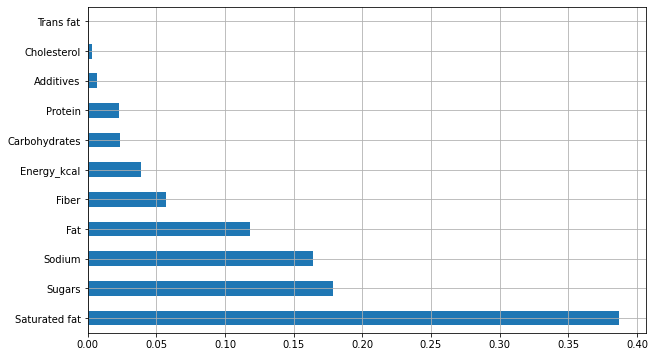

In [ ]:
feat_importances = pd.Series(feature_importances, index=X_train.columns)

plt.figure(figsize=(10,6))
feat_importances.nlargest(20).plot(kind='barh', grid=True)
plt.show()

**Comment:** According to feature_importance_, **Saturated fat** contributes the most to the Nutri-score. Surprisingly, **Additives** and **Cholesterol** contents contribute only a little importance in predicting the Nutrition score, and might merely be noise

###Save Model

In [ ]:
import joblib
# joblib.dump(pipe_rfr, "best_nutri_rfr.pkl")

# !cp "/content/best_nutri_rfr.pkl" "/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files"
# and later...
pipe_rfr = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/best_nutri_rfr_old1.pkl")